# WAVELET analysis and plots in Python

## This notebook is based on this [example](https://www.mathworks.com/help/wavelet/ref/wcoherence.html) MATLAB example.

In the example 2 sine waves are used as inputs to calculate:

> Wavelet for each signal

> Cross-wavelet

> Wavelet coherence


The python library used for the wavelet calculations is [PyWCT](https://github.com/regeirk/pycwt)

In [1]:
#Numpy
import numpy as np

#PyCWT
import pycwt as wavelet
from pycwt.helpers import find

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

#Scipy
from scipy.stats import norm

#Miscelaneous libraries
import copy

###Extra
import warnings
warnings.filterwarnings('ignore')

Text(0.5, 0, 'Time (seconds)')

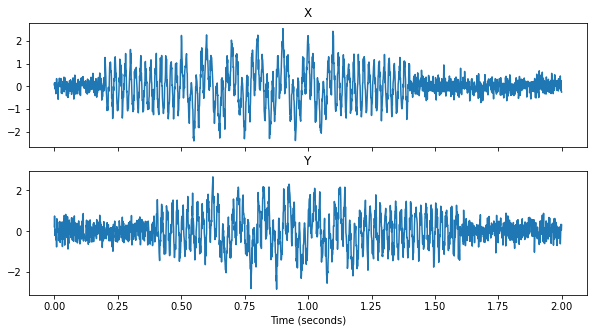

In [2]:
#Time
t = np.arange(0,2,0.001)

#Signal-1
x_1 = np.cos(2*np.pi*10*t)
x_1[:np.where(t<0.5)[0][-1]+1] = 0
x_1[np.where(t>=1.1)[0][0]+1:] = 0

x_2 = np.cos(2*np.pi*50*t)
x_2[:np.where(t<0.2)[0][-1]+1] = 0
x_2[np.where(t>=1.4)[0][0]+1:] = 0

x = x_1 + x_2 + .25*norm.ppf(np.random.rand(len(t))) ##norm.ppf reproduces exactly the same randn from MATLAB using the numpy np.random.rand


#Signal-2
y_1 = np.sin(2*np.pi*10*t)
y_1[:np.where(t<0.6)[0][-1]+1] = 0
y_1[np.where(t>=1.2)[0][0]+1:] = 0

y_2 = np.sin(2*np.pi*50*t)
y_2[:np.where(t<0.4)[0][-1]+1] = 0
y_2[np.where(t>=1.6)[0][0]+1:] = 0

y = y_1 + y_2 + .35*norm.ppf(np.random.rand(len(t)))


fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,5),sharex=True)

ax[0].plot(t,x)
ax[1].plot(t,y)

ax[0].set_title(r'X')
ax[1].set_title(r'Y')

ax[1].set_xlabel(r'Time (seconds)')

In [3]:
#to save arrays
np.savetxt("signal_x.dat",x)
np.savetxt("signal_y.dat",y)
np.savetxt("signal_t.dat",t)

In [4]:
def cont_wavelet(s,t,mother='morlet',slevel=.99):
    """ Calculate the continuos wavelet of a signal s
    
    Inputs: s (signal), t(time), mother(mother function) and slevel(Significance level)
    
    Outputs: [power,periods,significance at slevel, coi, dt]
    """
    
    dj = 1/12
    s0 = -1
    J = -1
    
    n = t.size #size of time array
    dt = np.diff(t)[0] #Cadence
    std = s.std() #standard deviation of signal
    alpha = 0 #Lag-1 autocorrelation 
    
    W, scales, freqs, coi, _,_ = wavelet.cwt(s/std,dt,dj,s0,J,mother) #calculate wavelet
    signifi, fft_theo = wavelet.significance(1.0,dt,scales,0,alpha,significance_level=slevel,wavelet=mother) #Fing significances array
    
    power = np.abs(W)**2 #Calculate power from wavalet
    periods = 1/freqs #Calculate periods from frequencies
    sig_slevel = np.ones([1,n]) * signifi[:,None]
    sig_slevel = power / sig_slevel #Where ratio is >1 power is significant
    
    return power,periods,sig_slevel,coi,dt
    

In [5]:
def cross_coh_wavelet(s1,s2,t1,t2,mother='morlet',slevel=.8646,MATLAB=False):
    """ Calculate the cross wavelet and coherence for 2 signals s1 and s2
    
    Inputs: s1,s2 (signals), t1,t2 (time arrays pressumed to have same cadence), mother(mother function) and slevel(Significance level)
    #recommended slevel = .8646 (equivalent to .95) check xwt function in PyCWT github (link in the beggining of the notebook)

    
    Outputs: [cross_power,cross_periods,cross_sig,cross_coi,WCT,coh_periods,coh_sig,u,v,dt]
    """
    # Due to the difference in the time series, the second signal has to be
    # trimmed for the XWT process.
    s2 = s2[np.argwhere((t2 >= min(t1)) & (t2 <= max(t1))).flatten()]
    
    dj = 1/12
    s0 = -1
    J = -1
    
    n1 = t1.size #size of time array
    dt = np.diff(t1)[0] #Cadence
    std1 = s1.std() #standard deviation of signal
    alpha1 = 0 #Lag-1 autocorrelation
    
    n2 = t2.size #size of time array
    std2 = s2.std() #standard deviation of signal
    alpha2 = 0 #Lag-1 autocorrelation 
    
    n = min(n1, n2)
    
    ### Cross-power wavelet calculation
    
    W12, cross_coi, freq, signif = wavelet.xwt(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                           significance_level=slevel,
                                           wavelet='morlet', normalize=True)
    
    
    cross_power = np.abs(W12)**2
    cross_sig = np.ones([1, n]) * signif[:, None]
    cross_sig = cross_power / cross_sig  # Power is significant where ratio > 1
    cross_periods = 1/freq
    
    
    ### Calculate the wavelet coherence (WTC).
    
    WCT, aWCT, corr_coi, freq, sig = wavelet.wct(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                             significance_level=slevel,
                                             wavelet='morlet', normalize=True,
                                             cache=True) ###Choose False if some parameter change and you want to re-do all the calculations

    coh_sig = np.ones([1, n]) * sig[:, None]
    coh_sig = np.abs(WCT) / coh_sig  # Power is significant where ratio > 1
    coh_periods = 1 / freq
    
    ### Arrows pointing direction for MATLAB=False:
    ##anti-phase: pointing downwards (and viceversa)
    ##X leads Y: pointing right (and viceversa)
    if MATLAB:
        angle=aWCT
    else:
        angle = 0.5 * np.pi - aWCT ### To reproduce same convention as in MATLAB make angle=aWCT
    u, v = np.cos(angle), np.sin(angle)
    
    return cross_power,cross_periods,cross_sig,cross_coi,WCT,coh_periods,coh_sig,cross_coi,u,v,dt
    

In [6]:
def plot_cont_wavelet(t,s,power,periods,sig_slevel,coi,dt,colormap = 'nipy_spectral'):
    """Makes the wavelet plot using a log-2 scale for the color table
    
    Inputs: time,signal + Outputs of cont_wavelet  and colormap ('nipy_spectral recommended')
    """

    
    
    fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(12,10),sharex=True)
    # sns.set_style('darkgrid')

    """PANEL SIGNAL"""

    axes[0].plot(t,s,'-k')
    axes[0].set_title(r'Signal',fontsize=23)
    axes[0].tick_params(axis='both', which='major', labelsize=17)

    """PANEL WAVELET"""
    cut_per = np.where(periods<periods.max()/2)[0][-1]
    levels = [np.nanmin(power[:cut_per,:])*1]
    for i in range(int(power.max()/4.5)):#49
        levels.append(levels[-1]*2)


    CS0 = axes[1].contourf(t, periods[:cut_per], np.log2(power[:cut_per,:]), levels=np.log2(levels),cmap=colormap)
    # 95# significance contour, levels at -99 (fake) and 1 (95# signif)
    axes[1].contour(t, periods[:cut_per], sig_slevel[:cut_per,:], [-99, 1], colors='k',linewidths=[1,3])


    # cone-of-influence, anything "below" is dubious
    axes[1].plot(t, coi[:], '--k',lw=3)
    axes[1].fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                               t[:1] - dt, t[:1] - dt]),
            np.concatenate([(coi), [1e-9], (periods[:cut_per][-1:]),
                               (periods[:cut_per][-1:]), [1e-9]]),
            'k', alpha=0.3, hatch='x')
    # format y-scale
    axes[1].set_yscale('log', basey=2, subsy=None)
    axes[1].set_ylim([np.min(periods[:cut_per]), np.max(periods[:cut_per])])
    axes[1].yaxis.set_major_formatter(ticker.ScalarFormatter())
    axes[1].ticklabel_format(axis='y', style='plain')
    axes[1].invert_yaxis()

    axes[1].set_xlim(max(t.min(), t.min()), min(t.max(), t.max()))

    axes[1].set_ylabel(r'Period [s]',fontsize=20)
    axes[1].set_xlabel(r'Time [s]',fontsize=20)

    axes[1].tick_params(axis='both', which='major', labelsize=17)


    axes[1].set_title("Wavelet of signal",fontsize=23)
    
    plt.tight_layout()


In [7]:
power_x,periods_x,sig_slevel_x,coi_x,dt_x = cont_wavelet(x,t)
power_y,periods_y,sig_slevel_y,coi_y,dt_y = cont_wavelet(y,t)
cross_power,cross_periods,cross_sig,cross_coi,coh_power,coh_periods,coh_sig,coh_coi,u,v,dt = cross_coh_wavelet(x,y,t,t)
cross_power_matlab,cross_periods_matlab,cross_sig_matlab,cross_coi_matlab,coh_power_matlab,coh_periods_matlab,coh_sig_matlab,coh_coi_matlab,u_matlab,v_matlab,dt_matlab = cross_coh_wavelet(x,y,t,t,MATLAB=True)

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.



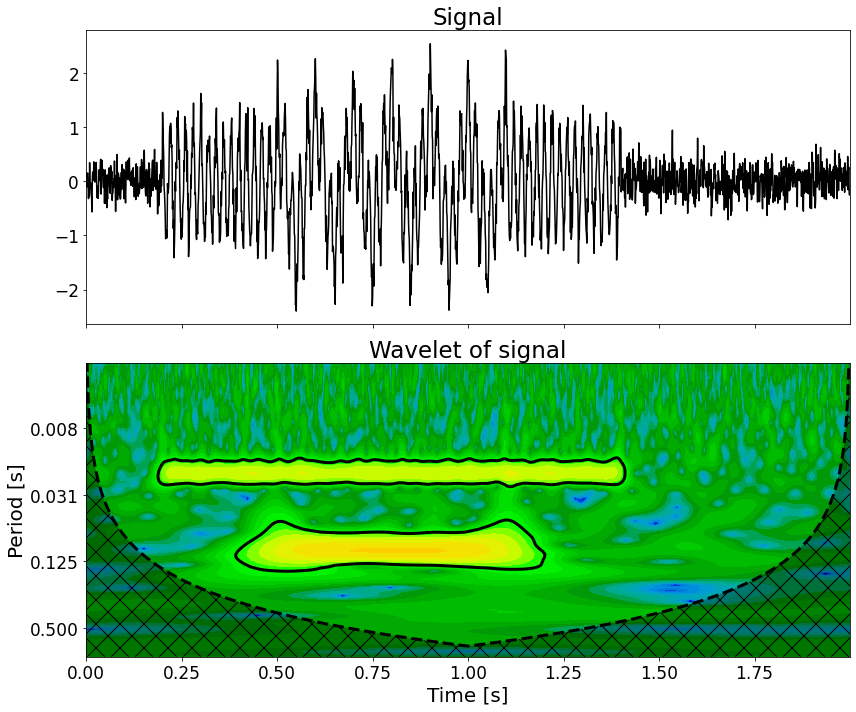

In [8]:
plot_cont_wavelet(t,x,power_x,periods_x,sig_slevel_x,coi_x,dt_x)

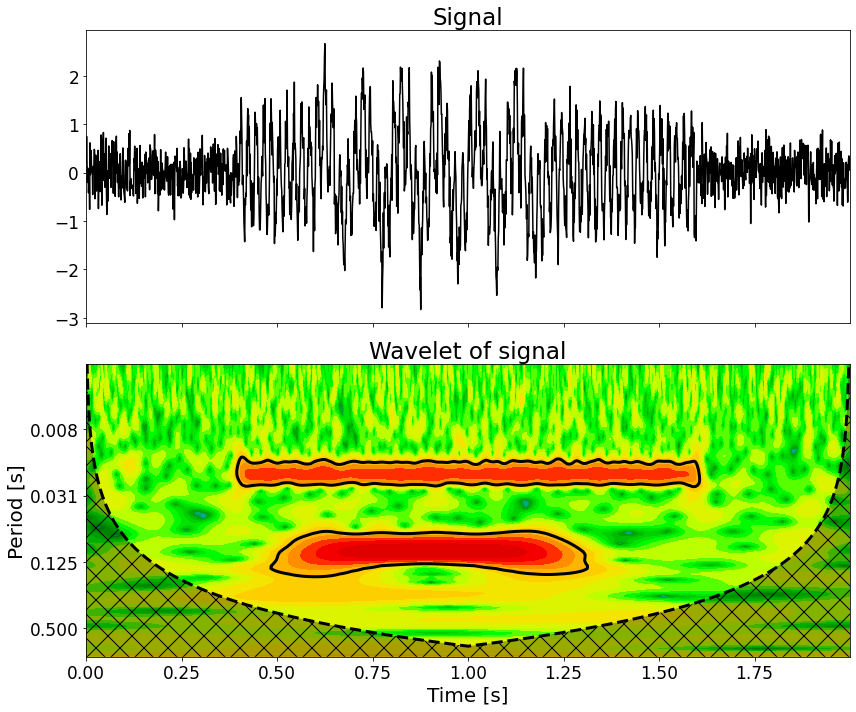

In [9]:
plot_cont_wavelet(t,y,power_y,periods_y,sig_slevel_y,coi_y,dt_y)

### Plot following MATLAB arrows convention

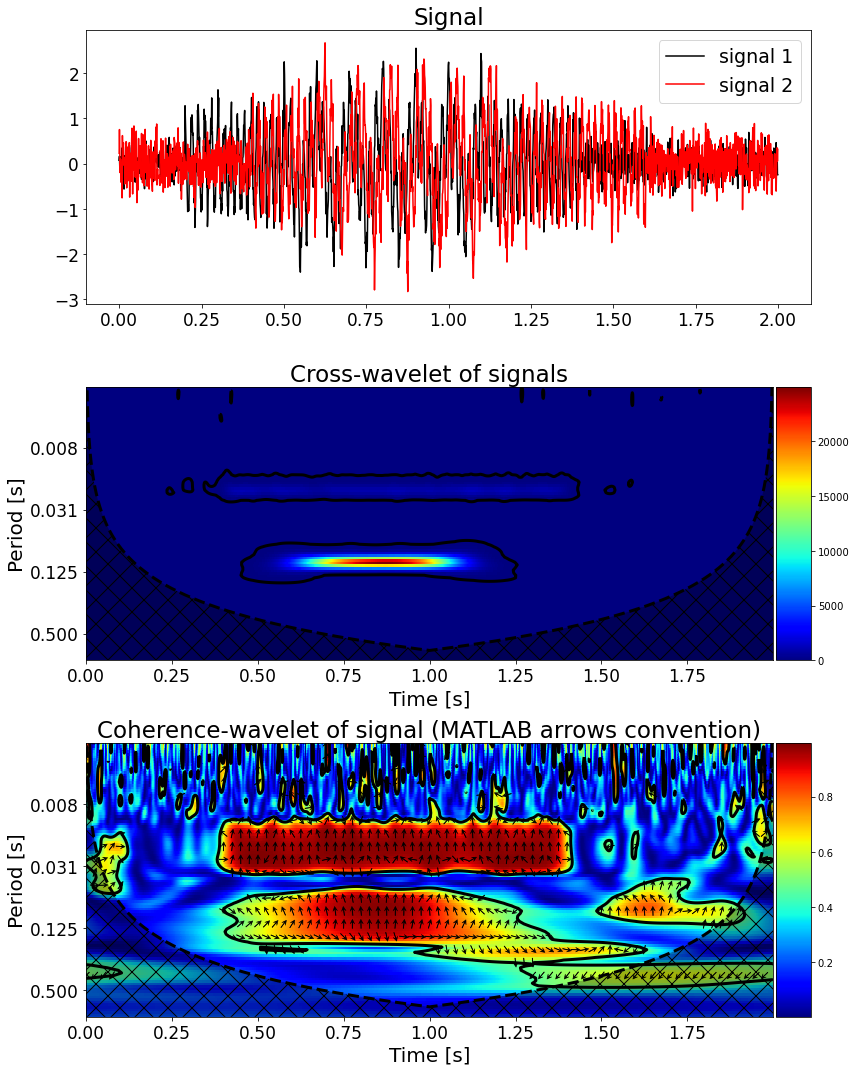

In [10]:


fig, axes = plt.subplots(ncols=1,nrows=3,figsize=(12,15))
# sns.set_style('darkgrid')
colormap='jet'

"""PANEL SIGNAL"""

axes[0].plot(t,x,'-k',label=r'signal 1')
axes[0].plot(t,y,'-r',label=r'signal 2')
axes[0].set_title(r'Signal',fontsize=23)
axes[0].tick_params(axis='both', which='major', labelsize=17)
axes[0].legend(fontsize=19)
axes[2].set_xlabel(r'Time [s]',fontsize=20)


"""PANEL CROSS-WAVELET"""
cut_per_matlab = np.where(cross_periods_matlab<cross_periods_matlab.max()/2)[0][-1]
# levels = [np.nanmin(power[:cut_per,:])*1]
# for i in range(int(power.max()/5)):#49
#     levels.append(levels[-1]*2)


im_cross = axes[1].pcolormesh(t, cross_periods_matlab[:cut_per_matlab], cross_power_matlab[:cut_per_matlab,:],cmap=colormap)
divider_cross = make_axes_locatable(axes[1])
cax_cross = divider_cross.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_cross, cax=cax_cross, orientation='vertical')
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
axes[1].contour(t, cross_periods_matlab[:cut_per_matlab], cross_sig_matlab[:cut_per_matlab,:], [-99, 1], colors='k',linewidths=[1,3])


# cone-of-influence, anything "below" is dubious
axes[1].plot(t, cross_coi_matlab[:], '--k',lw=3)
axes[1].fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([(cross_coi_matlab), [1e-9], (cross_periods_matlab[:cut_per_matlab][-1:]),
                           (cross_periods_matlab[:cut_per_matlab][-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
# format y-scale
axes[1].set_yscale('log', basey=2, subsy=None)
axes[1].set_ylim([np.min(cross_periods_matlab[:cut_per_matlab]), np.max(cross_periods_matlab[:cut_per_matlab])])
axes[1].yaxis.set_major_formatter(ticker.ScalarFormatter())
axes[1].ticklabel_format(axis='y', style='plain')
axes[1].invert_yaxis()

axes[1].set_xlim(max(t.min(), t.min()), min(t.max(), t.max()))

axes[1].set_ylabel(r'Period [s]',fontsize=20)
axes[1].set_xlabel(r'Time [s]',fontsize=20)

axes[1].tick_params(axis='both', which='major', labelsize=17)


axes[1].set_title("Cross-wavelet of signals",fontsize=23)

"""PANEL COH-WAVELET"""
cut_per = np.where(coh_periods_matlab<coh_periods_matlab.max()/2)[0][-1]
# levels = [np.nanmin(power[:cut_per,:])*1]
# for i in range(int(power.max()/5)):#49
#     levels.append(levels[-1]*2)


im_coh = axes[2].pcolormesh(t, coh_periods_matlab[:cut_per_matlab], coh_power_matlab[:cut_per_matlab,:],cmap=colormap)
divider_coh = make_axes_locatable(axes[2])
cax_coh = divider_coh.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_coh, cax=cax_coh, orientation='vertical')
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
axes[2].contour(t, coh_periods_matlab[:cut_per_matlab], coh_sig_matlab[:cut_per_matlab,:], [-99, 1], colors='k',linewidths=[1,3])


# cone-of-influence, anything "below" is dubious
axes[2].plot(t, coh_coi_matlab[:], '--k',lw=3)
axes[2].fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([(coh_coi_matlab), [1e-9], (coh_periods_matlab[:cut_per_matlab][-1:]),
                           (coh_periods_matlab[:cut_per_matlab][-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
# format y-scale
axes[2].set_yscale('log', basey=2, subsy=None)
axes[2].set_ylim([np.min(coh_periods_matlab[:cut_per_matlab]), np.max(coh_periods_matlab[:cut_per_matlab])])
axes[2].yaxis.set_major_formatter(ticker.ScalarFormatter())
axes[2].ticklabel_format(axis='y', style='plain')
axes[2].invert_yaxis()

###Masking u,v to keep only thos within significance
u_sig_matlab = copy.deepcopy(u_matlab)
v_sig_matlab = copy.deepcopy(v_matlab)
mask_sig_matlab = copy.deepcopy(coh_sig_matlab)
mask_sig_matlab[mask_sig_matlab>=1] = 1
mask_sig_matlab[mask_sig_matlab<1] = np.nan
u_sig_matlab  = u_sig_matlab*mask_sig_matlab
v_sig_matlab  = v_sig_matlab*mask_sig_matlab

axes[2].quiver(t[::25], coh_periods_matlab[:cut_per_matlab][::5], u_sig_matlab[:cut_per_matlab,:][::5, ::25], v_sig_matlab[:cut_per_matlab,:][::5, ::25], units='height',
           angles='uv', pivot='mid', linewidth=0.5, edgecolor='k',
           headwidth=10, headlength=10, headaxislength=5, minshaft=2,
           minlength=5)

axes[2].set_xlim(max(t.min(), t.min()), min(t.max(), t.max()))

axes[2].set_ylabel(r'Period [s]',fontsize=20)
axes[2].set_xlabel(r'Time [s]',fontsize=20)

axes[2].tick_params(axis='both', which='major', labelsize=17)


axes[2].set_title("Coherence-wavelet of signal (MATLAB arrows convention)",fontsize=23)

plt.tight_layout()

### Plot following this convention:

> anti-phase: pointing downwards (and viceversa)

> X leads Y: pointing right (and viceversa)

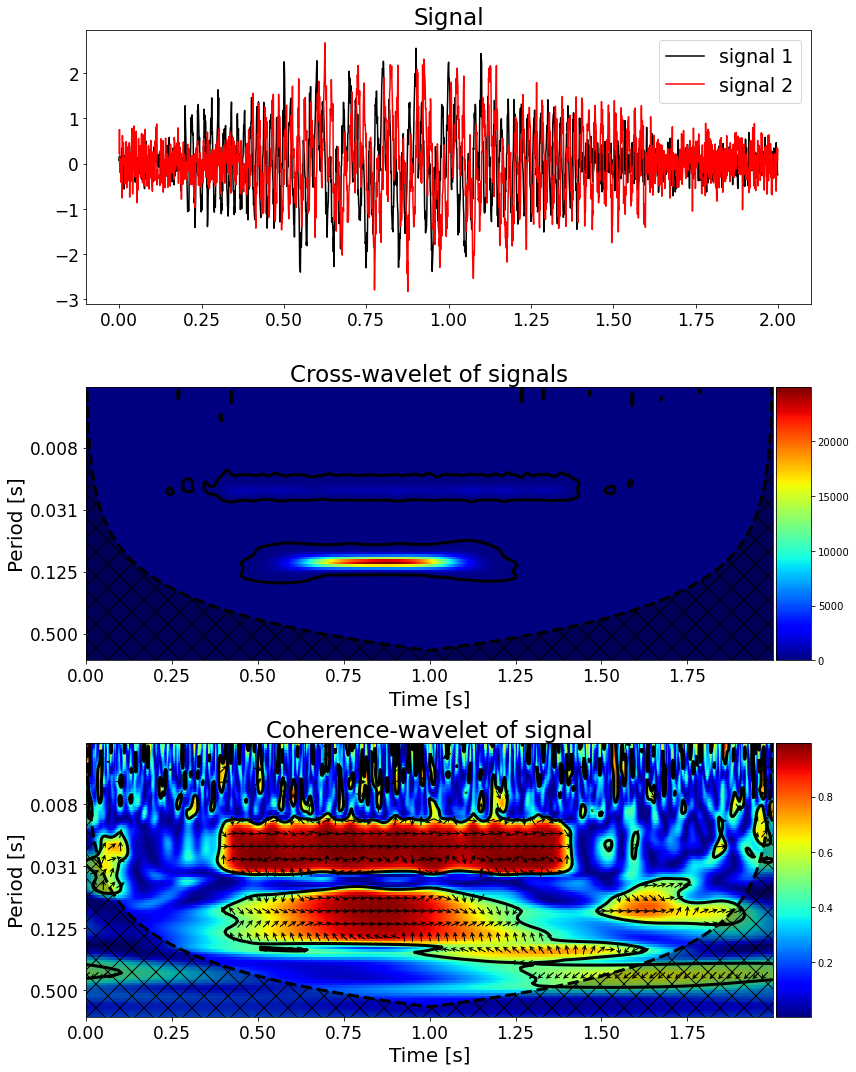

In [11]:


fig, axes = plt.subplots(ncols=1,nrows=3,figsize=(12,15))
# sns.set_style('darkgrid')
colormap='jet'

"""PANEL SIGNAL"""

axes[0].plot(t,x,'-k',label=r'signal 1')
axes[0].plot(t,y,'-r',label=r'signal 2')
axes[0].set_title(r'Signal',fontsize=23)
axes[0].tick_params(axis='both', which='major', labelsize=17)
axes[0].legend(fontsize=19)
axes[2].set_xlabel(r'Time [s]',fontsize=20)


"""PANEL CROSS-WAVELET"""
cut_per = np.where(cross_periods<cross_periods.max()/2)[0][-1]
# levels = [np.nanmin(power[:cut_per,:])*1]
# for i in range(int(power.max()/5)):#49
#     levels.append(levels[-1]*2)


im_cross = axes[1].pcolormesh(t, cross_periods[:cut_per], cross_power[:cut_per,:],cmap=colormap)
divider_cross = make_axes_locatable(axes[1])
cax_cross = divider_cross.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_cross, cax=cax_cross, orientation='vertical')
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
axes[1].contour(t, cross_periods[:cut_per], cross_sig[:cut_per,:], [-99, 1], colors='k',linewidths=[1,3])


# cone-of-influence, anything "below" is dubious
axes[1].plot(t, cross_coi[:], '--k',lw=3)
axes[1].fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([(cross_coi), [1e-9], (cross_periods[:cut_per][-1:]),
                           (cross_periods[:cut_per][-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
# format y-scale
axes[1].set_yscale('log', basey=2, subsy=None)
axes[1].set_ylim([np.min(cross_periods[:cut_per]), np.max(cross_periods[:cut_per])])
axes[1].yaxis.set_major_formatter(ticker.ScalarFormatter())
axes[1].ticklabel_format(axis='y', style='plain')
axes[1].invert_yaxis()

axes[1].set_xlim(max(t.min(), t.min()), min(t.max(), t.max()))

axes[1].set_ylabel(r'Period [s]',fontsize=20)
axes[1].set_xlabel(r'Time [s]',fontsize=20)

axes[1].tick_params(axis='both', which='major', labelsize=17)


axes[1].set_title("Cross-wavelet of signals",fontsize=23)

"""PANEL COH-WAVELET"""
cut_per = np.where(coh_periods<coh_periods.max()/2)[0][-1]
# levels = [np.nanmin(power[:cut_per,:])*1]
# for i in range(int(power.max()/5)):#49
#     levels.append(levels[-1]*2)


im_coh = axes[2].pcolormesh(t, coh_periods[:cut_per], coh_power[:cut_per,:],cmap=colormap)
divider_coh = make_axes_locatable(axes[2])
cax_coh = divider_coh.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_coh, cax=cax_coh, orientation='vertical')
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
axes[2].contour(t, coh_periods[:cut_per], coh_sig[:cut_per,:], [-99, 1], colors='k',linewidths=[1,3])


# cone-of-influence, anything "below" is dubious
axes[2].plot(t, coh_coi[:], '--k',lw=3)
axes[2].fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([(coh_coi), [1e-9], (coh_periods[:cut_per][-1:]),
                           (coh_periods[:cut_per][-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
# format y-scale
axes[2].set_yscale('log', basey=2, subsy=None)
axes[2].set_ylim([np.min(coh_periods[:cut_per]), np.max(coh_periods[:cut_per])])
axes[2].yaxis.set_major_formatter(ticker.ScalarFormatter())
axes[2].ticklabel_format(axis='y', style='plain')
axes[2].invert_yaxis()

###Masking u,v to keep only thos within significance
u_sig = copy.deepcopy(u)
v_sig = copy.deepcopy(v)
mask_sig = copy.deepcopy(coh_sig)
mask_sig[mask_sig>=1] = 1
mask_sig[mask_sig<1] = np.nan
u_sig  = u_sig*mask_sig
v_sig  = v_sig*mask_sig

axes[2].quiver(t[::25], coh_periods[:cut_per][::5], u_sig[:cut_per,:][::5, ::25], v_sig[:cut_per,:][::5, ::25], units='height',
           angles='uv', pivot='mid', linewidth=0.5, edgecolor='k',
           headwidth=10, headlength=10, headaxislength=5, minshaft=2,
           minlength=5)

axes[2].set_xlim(max(t.min(), t.min()), min(t.max(), t.max()))

axes[2].set_ylabel(r'Period [s]',fontsize=20)
axes[2].set_xlabel(r'Time [s]',fontsize=20)

axes[2].tick_params(axis='both', which='major', labelsize=17)


axes[2].set_title("Coherence-wavelet of signal",fontsize=23)

plt.tight_layout()